In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
# import torchvision.datasets as dsets
# import torchvision.transforms as transforms
from torch.autograd import Variable
import pickle
import numpy as np
import random

with open('./raf_test.pkl', 'rb') as f:
     test_data = pickle.load(f)
print('load test done')

regions = torch.Tensor(test_data[2])# (12198,11,96,96,3)
re = regions[:, :10]
print('1')
points = torch.Tensor(test_data[1])# (12198,10,2)
print('2')
labels = torch.LongTensor(test_data[0])#(12198)
print('3')



load test done
1
2
3


In [2]:
from torch.nn.modules.module import Module
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self,in_features, out_features, bias=True): #(shape256, 256)
        super(GraphConvolution, self).__init__()
        # (A*X*W)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        # inputs (b,10,256)
        # ajd (b,10,10)
        x = x.view(-1,256)
        support = torch.mm(x, self.weight) #(b*10,256)
        support = support.view(-1,10,support.size(1))
        output = torch.bmm(adj, support) #(b,10,10)*(b,10.256)  (b,10,256)
        if self.bias is not None:
            #print(output.shape,self.bias.shape)
            return output + self.bias
        else:
            return output
class GCN(nn.Module):
    def __init__(self,nfeat):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, 256)
        self.gc2 = GraphConvolution(256, 256)
        self.fc1 = nn.Linear(256*10, 1024)
        self.fc2 = nn.Linear(1024, 7)  
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x, adj):
        # x = self.dropout(F.relu(self.gc1(x, adj)))
        # x = self.gc2(x, adj) #(-1,10,256)
        x = F.relu(self.gc1(x, adj))
        x = self.dropout(x.view(x.size(0),-1))      
        x = self.fc1(x)
        x = self.fc2(x)
        out = F.softmax(x, dim=1)
        return out
    
    
def get_batch_graph(inp,k=8):
    assert len(inp.shape) == 3
    x=inp
    norm1 = torch.sum(x**2,axis=2).reshape((x.shape[0],-1,1))
    norm2 = torch.sum(x**2,axis=2).reshape((x.shape[0],1,-1))
    dist = torch.bmm(x,x.permute(0,2,1))*(-2)+norm1+norm2
    sigma2 = torch.mean(dist,axis=2).reshape(-1,10,1)
    dist = torch.exp(-dist/sigma2)
    return dist



class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 1-2 conv layer
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 1 Pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(

            # 2-1 conv layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 2-2 conv layer
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 2 Pooling lyaer
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(

            # 3-1 conv layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # 3-2 conv layer
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # 3 Pooling layer
            # nn.MaxPool2d(kernel_size=2, stride=2))
            nn.AvgPool2d(kernel_size=24, stride=24))
        

        self.layer6 = nn.Sequential(

            # 6 Fully connected layer
            nn.Linear(256, 256),
            # nn.Dropout(),
            nn.ReLU())


        self.layer7 = nn.Sequential(

            # 7 Fully connected layer
            nn.Linear(256*10, 1024),
            nn.Dropout(),
            nn.ReLU())

        self.layer8 = nn.Sequential(

            # 8 output layer
            nn.Linear(1024, 7),
            nn.Softmax())

    def forward(self, x):
        # x.shape ==(-1,10,96,96,3)
        out = []
        for k in range(10):
            #print(k)
            f = x[:,k,:,:,:]
            f = f.permute(0,3,1,2) 
            #（-1，3，96，96）
            f = self.layer1(f)  
            # (-1, 64, 48, 48)
            f = self.layer2(f)  
            # (-1, 128, 24, 24)
            f = self.layer3(f)  
            # (-1, 256, 1, 1)
            f = f.view(f.size(0),-1)
            # (-1, 256)
            # f = self.layer6(f)
            # (-1, 256)
            out.append(f)
        out = torch.cat(out,axis=1) 
        #  (-1, 256*10)
        return out

In [4]:
from torch.nn.parameter import Parameter
import math
import torch.nn.functional as F
adjs = get_batch_graph(points)
BATCH_SIZE = 4
index = [i for i in range(3068)]
vgg16 = VGG16()
vgg16.cuda()
checkpoint = torch.load('./RAFDB/vgg_dropout_epoch349.pkl')
vgg16.load_state_dict(checkpoint['net'])
vgg16.eval()
gcn =  GCN(256)
for i in range(9, 109, 10):
    print(i)
    path = './RAFDB/gcnfea' + str(i) +'.pkl'
    check = torch.load(path)
    # from collections import OrderedDict
    # new_check = OrderedDict()
    # for k, v in checkpoint.items():
    #     if 'module' not in k:
    #         k = 'module.'+k
    #     else:
    #         k = k.replace('features.module.', 'module.features.')
    #     new_check[k]=v

    gcn.load_state_dict(check['net'])
    gcn.cuda()

    # Test the model
    gcn.eval()
    correct = 0
    total = 0

    for i in range(767):
        tmp = index[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        img = Variable(re[tmp]).cuda()
        outputs = vgg16(img)  #(16, 256*10)
        outputs = outputs.reshape(-1, 10, 256)
        label = Variable(labels[tmp]).cuda()
        adj = adjs[tmp].cuda()
        out = gcn.forward(outputs,adj)
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum()
    print(correct, total)
    print('Test Accuracy of the model on the test images: %f %%' % (100 * correct / total))

9
tensor(1839, device='cuda:0') 3068
Test Accuracy of the model on the test images: 59.000000 %
19
tensor(1846, device='cuda:0') 3068
Test Accuracy of the model on the test images: 60.000000 %
29
tensor(2004, device='cuda:0') 3068
Test Accuracy of the model on the test images: 65.000000 %
39
tensor(2006, device='cuda:0') 3068
Test Accuracy of the model on the test images: 65.000000 %
49


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import pickle
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import numpy as np
from IPython import embed
import torch.nn.functional as F

with open('./raf_test_96.pkl', 'rb') as f:
     test_data = pickle.load(f)
print('load test done')

# testData = TensorDataset((torch.Tensor(test_data[2]))[:, :10], torch.LongTensor(test_data[0]))
# # testData = TensorDataset(torch.Tensor(test_data[2]), torch.LongTensor(test_data[0]))
# print('to tensor done')

# testLoader = DataLoader(dataset=testData, batch_size=1, shuffle=False)
# print('dataloader done')




load test done


In [ ]:
testData = TensorDataset(torch.Tensor(test_data[2]), torch.LongTensor(test_data[0]))
print('to tensor done')

testLoader = DataLoader(dataset=testData, batch_size=2, shuffle=False)
print('dataloader done')

In [3]:
class VGG16(nn.Module):  # vgg-11
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(33, 64, kernel_size=3, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 7),
            nn.Softmax()
        )
        

    def forward(self, x):
        inp = []
        for k in range(11):
            f = x[:,k,:,:,:]
            f = f.permute(0,3,1,2) 
            inp.append(f)
        inp = torch.cat(inp, axis=1)
        out = self.features(inp)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out



vgg16 = VGG16()

path = './RAFDB/vgg11allepoch189.pkl'
from collections import OrderedDict
# def myOwnLoad(model, check):
#     modelState = model.state_dict()
#     tempState = OrderedDict()
#     for i in range(len(check.keys())):
#         # print modelState.keys()[i], check.keys()[i]
#         tempState[modelState.keys()[i]] = check[check.keys()[i]]

#     model.load_state_dict(tempState)
#     return model
state_dictBA = torch.load(path)['net']
# create new OrderedDict that does not contain `module.`
new_state_dictBA = OrderedDict()
for k, v in state_dictBA.items():
    name = k[7:] # remove `module.`
    new_state_dictBA[name] = v
vgg16.load_state_dict(new_state_dictBA)


# checkpoint = torch.load(path)
# vgg16 = myOwnLoad(vgg16, checkpoint['net'])
# vgg16.load_state_dict(checkpoint['net'])
vgg16.cuda()

# Test the model
vgg16.eval()

images = Variable(img).cuda()
outputs = vgg16(images)


RuntimeError: Error(s) in loading state_dict for VGG16:
	Unexpected key(s) in state_dict: "features.3.weight", "features.3.bias", "features.6.weight", "features.6.bias", "features.8.weight", "features.8.bias", "features.10.weight", "features.10.bias". 

In [25]:
outputs[0][10,:,:]

tensor([[0.0000, 6.0277],
        [0.0000, 0.0000]], device='cuda:0', grad_fn=<SliceBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


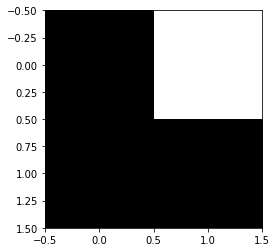

In [27]:
import matplotlib.pyplot as plt
import numpy as np
f = outputs[0][10].cpu().detach().numpy()
f = f.reshape(2,2,1)
a = np.concatenate((f,f,f), axis=2)
plt.imshow(a) #（R,G,B）
# plt.imshow(f,cmap='gray') #（R,G,B）

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


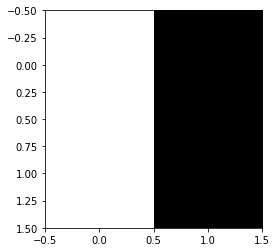

In [17]:
plt.imshow(a) #（R,G,B）